C:\Users\user\AppData\Local\Temp\ipykernel_16912\3889619331.py:53: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"]   = df["ds"].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 8
[LightGBM] [Info] Start training from score 11.209267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 6984, number of used features: 8
[LightGBM] [Info] Start training from score 11.171286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

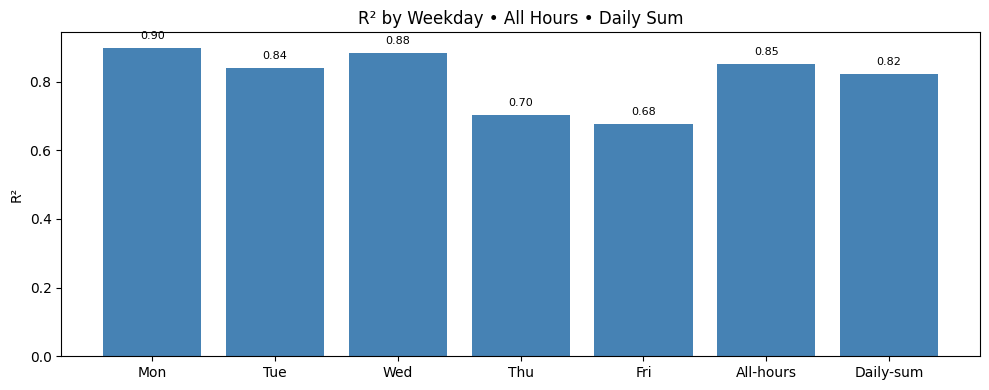

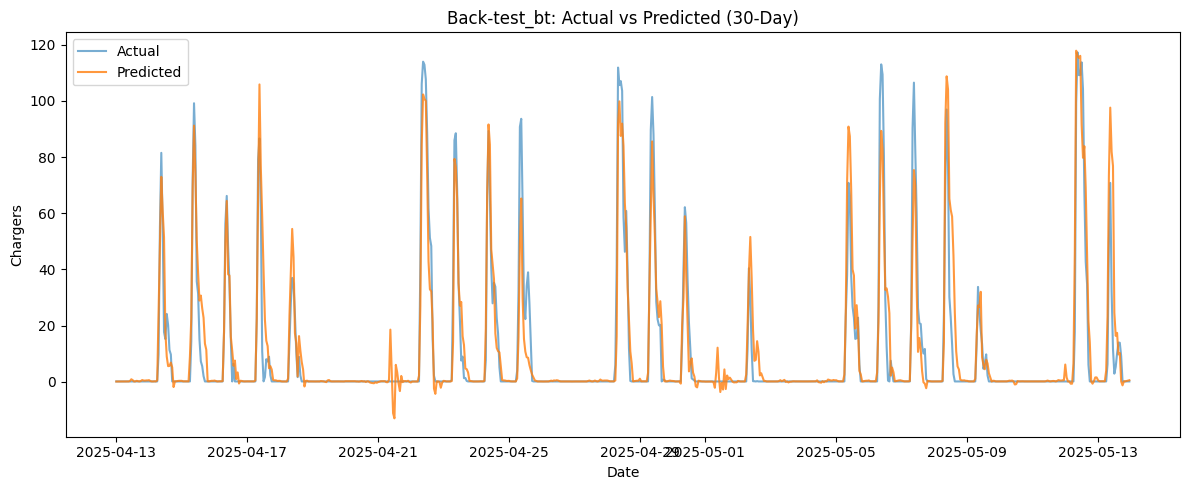

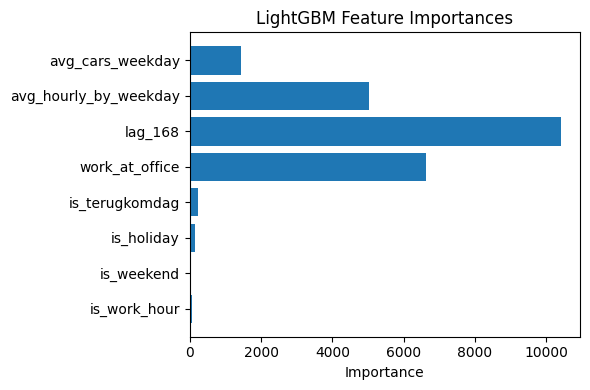

In [4]:
# ───────────────────────────── imports ─────────────────────────────
import numpy as np, pandas as pd, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ──────────────────────────── config ──────────────────────────────
CHARGING_FILE = "../charging_forecasts/Charging_data_hourly.csv"      # hourly EV kWh
CALENDAR_FILE = "../layout1_full_calendar_2023-2025.csv"              # workforce
TEMP_FILE     = "../api_data/daily_temperature_data2.csv"               # DAILY °C

TOTAL_HEADCOUNT = 105
SESSION_KWH     = 9.5

# ───────────────────── 1  LOAD CHARGING DATA ─────────────────────
df = pd.read_csv(CHARGING_FILE).rename(columns={"Date": "ds", "Chargers": "y"})
df["ds"] = pd.to_datetime(df["ds"])
df = df.sort_values("ds").reset_index(drop=True)
df["cal_date"] = df["ds"].dt.date                     # day key for joins

# ───────────────────── 1b  DAILY TEMPERATURE MERGE ───────────────
if Path(TEMP_FILE).exists():
    tdf = (pd.read_csv(TEMP_FILE, parse_dates=["date"])
             .rename(columns={"date": "cal_date"}))   # keep only needed cols
    tdf["cal_date"] = tdf["cal_date"].dt.date
    df = df.merge(tdf[["cal_date", "temperature_2m_max"]], on="cal_date", how="left")

# ───────────────────── 2  WORKFORCE CALENDAR ─────────────────────
cal = (pd.read_csv(CALENDAR_FILE, parse_dates=["Datum"])
         .rename(columns={
             "Datum":              "cal_date",
             "Totaal_Vakantiedagen":"vacation_cnt",
             "Totaal_Thuiswerkdagen":"homework_cnt"}))
cal["cal_date"] = cal["cal_date"].dt.date

df = df.merge(cal[["cal_date", "vacation_cnt", "homework_cnt"]],
              on="cal_date", how="left")
df[["vacation_cnt","homework_cnt"]] = df[["vacation_cnt","homework_cnt"]].fillna(0).astype(int)

# ───────────────────── 3  TIME / HOLIDAY FLAGS ───────────────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06"
]).normalize()
be_holidays = holidays.Belgium(years=df["ds"].dt.year.unique())

df["weekday"]      = df["ds"].dt.weekday
df["hour"]         = df["ds"].dt.hour
df["is_weekend"]   = (df["weekday"] >= 5).astype(int)
df["is_work_hour"] = df["hour"].between(8, 18).astype(int)
df["is_holiday"]   = df["ds"].dt.normalize().isin(be_holidays).astype(int)
df["is_terugkomdag"]= df["ds"].dt.normalize().isin(tkd).astype(int)

# ───────────────────── 4  work_at_office FEATURE ─────────────────
mask_work = (df["weekday"] < 5) & (df["is_holiday"] == 0) & df["is_work_hour"]
df["work_at_office"] = np.where(
    mask_work,
    (TOTAL_HEADCOUNT - df["vacation_cnt"] - df["homework_cnt"]).clip(lower=0),
    0
)

# ───────────────────── 5  ROLLING 30-DAY BACK-TEST ───────────────
start_eval = df["ds"].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(), df["ds"].max().normalize(), freq="D")

all_preds = []
for day in days_iter:
    day_start = pd.Timestamp(day)
    train = df[df["ds"] < day_start].copy()

    # hourly mean by weekday-hour
    avg_map = (train.groupby(["weekday","hour"])["y"]
                     .mean().rename("avg_hourly_by_weekday").reset_index())

    train["lag_168"] = train["y"].shift(168).fillna(train["y"].mean())
    train = train.merge(avg_map, on=["weekday","hour"], how="left")

    train["avg_cars_weekday"] = train.groupby("weekday")["y"].transform("mean") / SESSION_KWH

    FEATURES = [
        "is_work_hour","is_weekend",
        "is_holiday","is_terugkomdag",
        "work_at_office",
        "lag_168","avg_hourly_by_weekday","avg_cars_weekday"
    ]
    if "temperature" in df.columns:
        FEATURES.append("temperature")

    model = lgb.LGBMRegressor(
        objective="regression", n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train["y"])

    # day frame
    day_df = df[(df["ds"] >= day_start) & (df["ds"] < day_start + pd.Timedelta(days=1))].copy()
    day_df = day_df.merge(avg_map, on=["weekday","hour"], how="left")

    lag_df = train[["ds","y"]].copy()
    lag_df["ds"] += pd.Timedelta(days=7)
    lag_df.rename(columns={"y":"lag_168"}, inplace=True)
    day_df = day_df.merge(lag_df, on="ds", how="left")
    day_df["lag_168"] = day_df["lag_168"].fillna(day_df["avg_hourly_by_weekday"])

    cars_map = (train.groupby("weekday")["y"].mean() / SESSION_KWH
                ).rename("avg_cars_weekday").reset_index()
    day_df = day_df.merge(cars_map, on="weekday", how="left")

    day_df["yhat"] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[["ds","y","yhat","weekday"]])

test_bt = pd.concat(all_preds).sort_values("ds").reset_index(drop=True)

# ───────────────────── 6  METRICS ────────────────────────────────
mae  = mean_absolute_error(test_bt["y"], test_bt["yhat"])
rmse = np.sqrt(mean_squared_error(test_bt["y"], test_bt["yhat"]))
r2   = r2_score(test_bt["y"], test_bt["yhat"])

print("\n--- Back-test Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# (plots remain unchanged)
# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {
    weekday_map[d]:
    r2_score(
        test_bt.loc[test_bt['weekday']==d,'y'],
        test_bt.loc[test_bt['weekday']==d,'yhat']
    )
    for d in range(5)
}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
    y_sum=('y','sum'),
    yhat_sum=('yhat','sum')
)
r2_daily = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 8. PLOTS ════════════════════════════════════════════════
# R² bar plot
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily]
plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Time-series plot & feature importances
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test_bt: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

--- Baseline Forecaster (Avg Hourly by Weekday) ---
Test window: 2025-04-13 to 2025-05-13
MAE : 5.83 kWh
RMSE: 13.75 kWh
R²  : 0.690


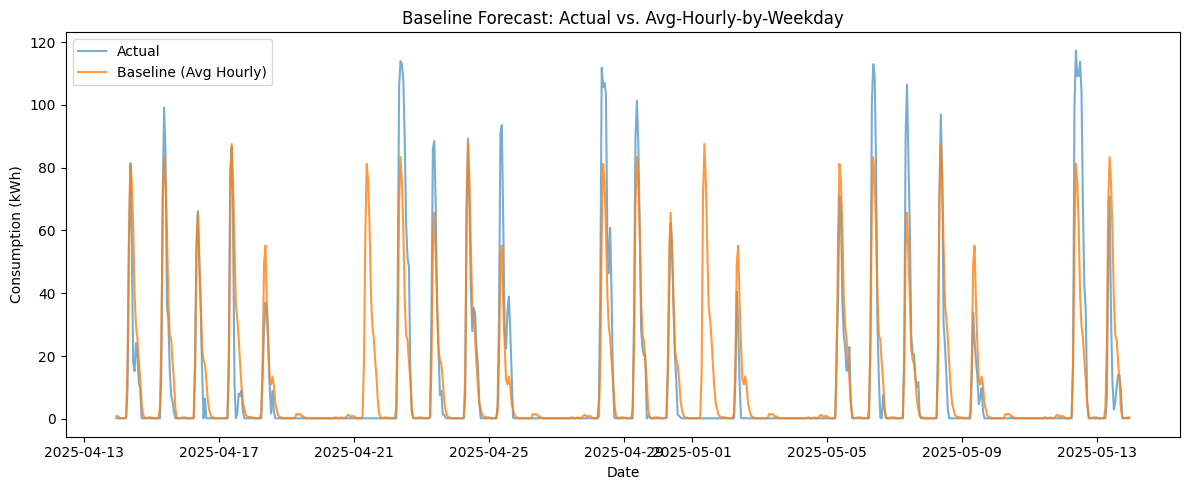

In [9]:

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. LOAD DATA
df = pd.read_csv("./Charging_data_hourly.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers':'y'})  # hourly kWh

# 2. DEFINE TEST WINDOW (LAST 30 DAYS)
end_test = df['ds'].max()
start_test = end_test - pd.Timedelta(days=30)
test = df[df['ds'] >= start_test].copy()
train = df[df['ds'] < start_test].copy()

# Ensure weekday/hour columns on df
train['weekday'] = train['ds'].dt.weekday
train['hour']    = train['ds'].dt.hour

test['weekday'] = test['ds'].dt.weekday
test['hour']    = test['ds'].dt.hour


# 3. BASELINE: AVERAGE HOURLY PATTERN BY WEEKDAY & HOUR
#    Compute on training data
avg_map = (
    train.groupby(['weekday','hour'])['y']
         .mean()
         .rename('yhat_baseline')
         .reset_index()
)


# Merge baseline predictions onto test set
test = test.merge(avg_map, on=['weekday','hour'], how='left')

# 4. EVALUATE BASELINE
y_true = test['y'].values
y_pred = test['yhat_baseline'].values

mae   = mean_absolute_error(y_true, y_pred)
rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
r2    = r2_score(y_true, y_pred)

print("--- Baseline Forecaster (Avg Hourly by Weekday) ---")
print(f"Test window: {start_test.date()} to {end_test.date()}")
print(f"MAE : {mae:.2f} kWh")
print(f"RMSE: {rmse:.2f} kWh")
print(f"R²  : {r2:.3f}")

# 5. PLOT ACTUAL vs BASELINE
plt.figure(figsize=(12,5))
plt.plot(test['ds'], y_true, label='Actual', alpha=0.6)
plt.plot(test['ds'], y_pred, label='Baseline (Avg Hourly)', alpha=0.8)
plt.title('Baseline Forecast: Actual vs. Avg-Hourly-by-Weekday')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_2280\2455390629.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 6983, number of used features: 8
[LightGBM] [Info] Start training from score 0.188000

--- Back-test Metrics (Last 30 Days) ---
MAE : 3.46
RMSE: 8.35
R²  : 0.89


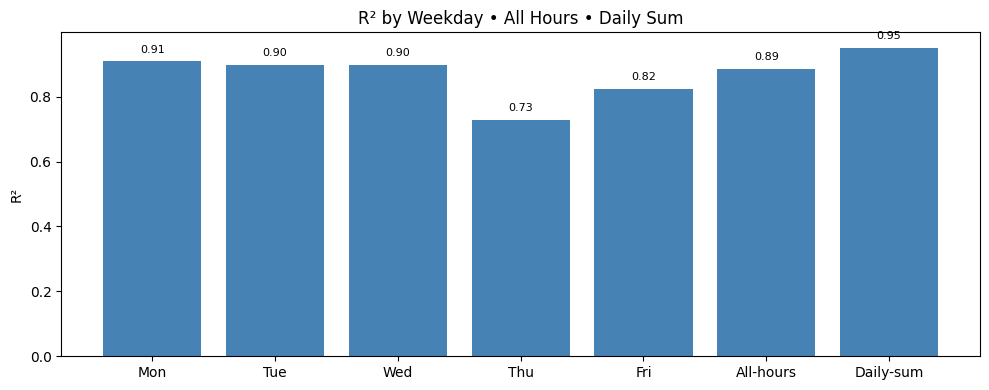

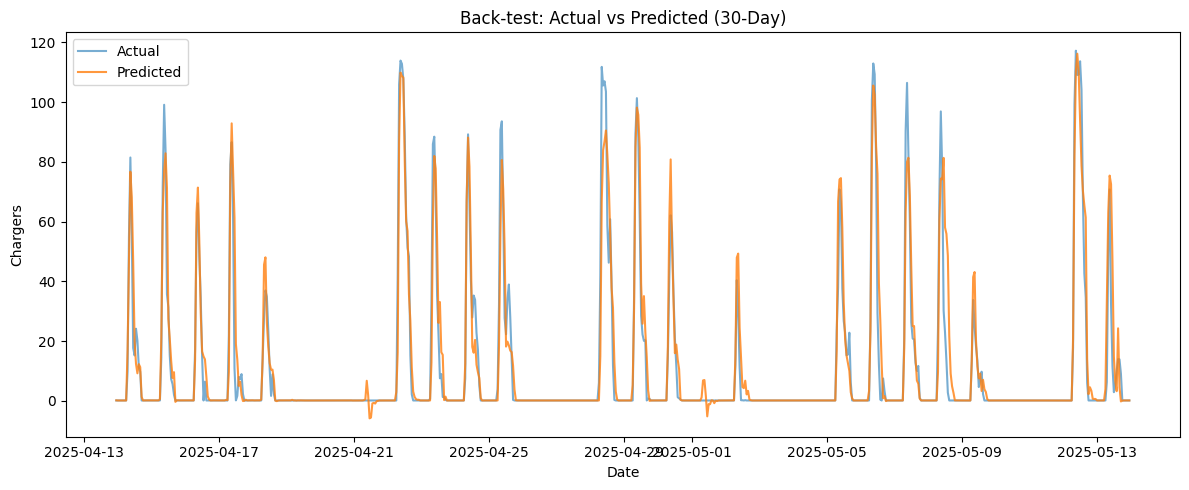

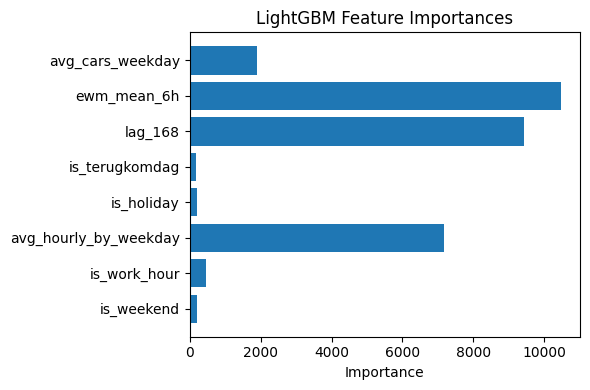

In [20]:
import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ═════════════════ 1. LOAD DATA ══════════════════════════════════════════════
df = pd.read_csv("./Charging_data_hourly.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})       # hourly kWh

# ═════════════════ 2. CALENDAR FLAGS ════════════════════════════════════════
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# ═════════════════ 3. TIME-BASED FEATURES ════════════════════════════════════
df['weekday']      = df['ds'].dt.weekday          # 0 = Mon
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# ═════════════════ 4. SPLIT TRAIN / TEST (30-day back-test) ═════════════════
start_backtest = df['ds'].max() - pd.Timedelta(days=30)
train_bt = df[df['ds'] < start_backtest].copy()
test_bt  = df[df['ds'] >= start_backtest].copy()

# ═════════════════ 5. TRAIN-ONLY STATISTICS (NO LEAKAGE) ════════════════════
# 5a. Avg energy pattern (weekday, hour) from training set
avg_map = (
    train_bt.groupby(['weekday','hour'])['y']
            .mean()
            .rename('avg_hourly_by_weekday')
            .reset_index()
)
train_bt = train_bt.merge(avg_map, on=['weekday','hour'], how='left')
test_bt  = test_bt .merge(avg_map, on=['weekday','hour'], how='left')

# 5b. Avg cars charged per weekday (training set)
SESSION_KWH      = 9.5
train_bt['cars_charged_hour'] = train_bt['y'] / SESSION_KWH
weekday_car_avg = (
    train_bt.groupby('weekday')['cars_charged_hour']
            .mean()
            .rename('avg_cars_weekday')
            .reset_index()
)
train_bt = train_bt.merge(weekday_car_avg, on='weekday', how='left')
test_bt  = test_bt .merge(weekday_car_avg, on='weekday', how='left')

# ═════════════════ 6. LAG & ROLLING FEATURES (available at prediction time) ═
for frame in (train_bt, test_bt):
    frame['lag_168']     = frame['y'].shift(168)
    frame['lag_168']     = frame['lag_168'].fillna(frame['avg_hourly_by_weekday'])
    frame['ewm_mean_6h'] = frame['y'].shift(1).ewm(span=6, adjust=False).mean()
    frame.loc[frame['is_holiday'] == 1, 'ewm_mean_6h'] = 0

# drop helper column from training
train_bt.drop(columns=['cars_charged_hour'], inplace=True)

# ═════════════════ 7. FINAL FEATURE LIST ════════════════════════════════════
FEATURES = [
    'is_weekend','is_work_hour','avg_hourly_by_weekday',
    'is_holiday','is_terugkomdag',
    'lag_168','ewm_mean_6h',
    'avg_cars_weekday'
]

# ═════════════════ 8. TRAIN & PREDICT ═══════════════════════════════════════
model = lgb.LGBMRegressor(
    objective='quantile', alpha=0.55,
    n_estimators=1000, learning_rate=0.05,
    random_state=42
).fit(train_bt[FEATURES], train_bt['y'])

test_bt['yhat'] = model.predict(test_bt[FEATURES])

# ═════════════════ 9. METRICS ═══════════════════════════════════════════════
mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {weekday_map[d]:
            r2_score(test_bt.loc[test_bt['weekday']==d,'y'],
                     test_bt.loc[test_bt['weekday']==d,'yhat'])
            for d in range(5)}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
        y_sum=('y','sum'), yhat_sum=('yhat','sum'))
r2_daily_sum = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 10. R² BAR PLOT ══════════════════════════════════════════
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily_sum]

plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar,v in zip(bars,values):
    plt.text(bar.get_x()+bar.get_width()/2, v+0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout(); plt.show()

# ═════════════════ 11. TIME-SERIES PLOT & FEATURE IMPORTANCE ════════════════
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_2280\3015453040.py:26: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['date_norm'].isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 6983, number of used features: 6
[LightGBM] [Info] Start training from score 11.172863

--- Back-test Metrics (Last 30 Days) ---
MAE : 4.23
RMSE: 9.52
R²  : 0.85


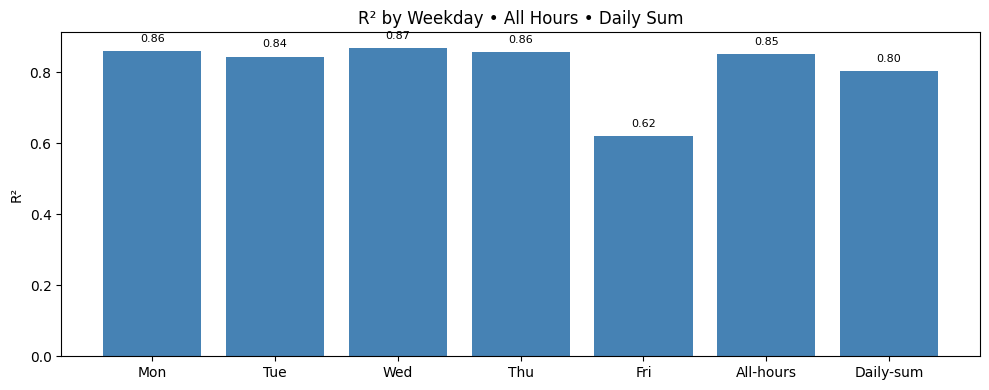

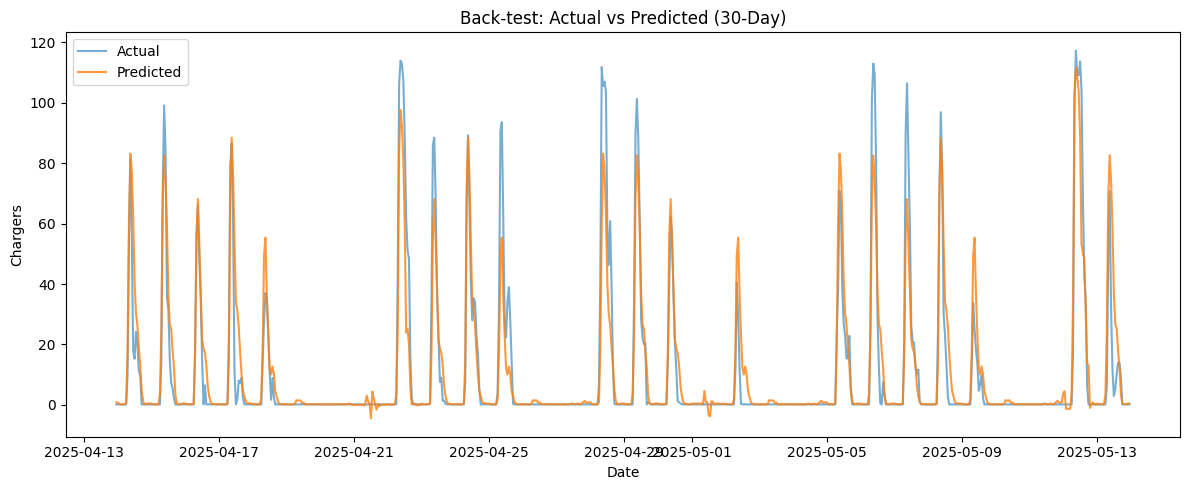

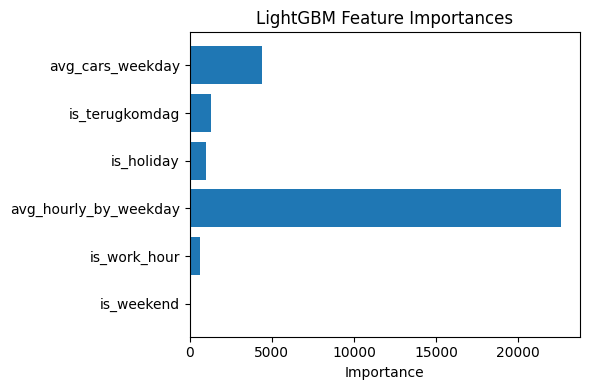

In [21]:
import pandas as pd
import numpy as np
import holidays
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ═════════════════ 1. LOAD & PREP ══════════════════════════════════════════════
df = pd.read_csv("./Charging_data_hourly.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})  # hourly kWh

# ═════════════════ 2. CALENDAR & TIME FEATURES ════════════════════════════════
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['date_norm']      = df['ds'].dt.normalize()
df['is_terugkomdag'] = df['date_norm'].isin(tkd).astype(int)
df['is_holiday']     = df['date_norm'].isin(be_holidays).astype(int)
df['weekday']        = df['ds'].dt.weekday
df['hour']           = df['ds'].dt.hour
df['is_weekend']     = (df['weekday'] >= 5).astype(int)
df['is_work_hour']   = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# ═════════════════ 3. SPLIT TRAIN / TEST (30-day back-test) ════════════════════
cutoff = df['ds'].max() - pd.Timedelta(days=30)
train = df[df['ds'] < cutoff].copy()
test  = df[df['ds'] >= cutoff].copy()

# ═════════════════ 4. TRAIN‐ONLY AGGREGATES ══════════════════════════════════
# 4a: avg energy by (weekday,hour)
avg_map = (
    train.groupby(['weekday','hour'])['y']
         .mean()
         .rename('avg_hourly_by_weekday')
         .reset_index()
)
train = train.merge(avg_map, on=['weekday','hour'], how='left')
test  = test.merge(avg_map,  on=['weekday','hour'], how='left')

# 4b: avg cars per weekday
SESSION_KWH = 9.5
train['cars_charged_hour'] = train['y'] / SESSION_KWH
weekday_car_avg = (
    train.groupby('weekday')['cars_charged_hour']
         .mean()
         .rename('avg_cars_weekday')
         .reset_index()
)
train = train.merge(weekday_car_avg, on='weekday', how='left')
test  = test .merge(weekday_car_avg, on='weekday', how='left')
train.drop(columns=['cars_charged_hour'], inplace=True)

# ═════════════════ 5. FINAL FEATURE LIST (no lag/ewm) ═════════════════════════
FEATURES = [
    'is_weekend',
    'is_work_hour',
    'avg_hourly_by_weekday',
    'is_holiday',
    'is_terugkomdag',
    'avg_cars_weekday',
    
]

# ═════════════════ 6. TRAIN & PREDICT ════════════════════════════════════════
model = lgb.LGBMRegressor(
    objective='regression',
    alpha=0.55,
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)
model.fit(train[FEATURES], train['y'])
test['yhat'] = model.predict(test[FEATURES])

# ═════════════════ 7. METRICS ════════════════════════════════════════════════
mae  = mean_absolute_error(test['y'], test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], test['yhat']))
r2   = r2_score(test['y'], test['yhat'])

print("\n--- Back-test Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {
    weekday_map[d]:
    r2_score(
        test.loc[test['weekday']==d,'y'],
        test.loc[test['weekday']==d,'yhat']
    )
    for d in range(5)
}

# R² on daily sums
daily = test.groupby(test['ds'].dt.date).agg(
    y_sum=('y','sum'),
    yhat_sum=('yhat','sum')
)
r2_daily = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 8. PLOTS ════════════════════════════════════════════════
# R² bar plot
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily]
plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Time-series plot & feature importances
plt.figure(figsize=(12,5))
plt.plot(test['ds'], test['y'],    label='Actual',    alpha=0.6)
plt.plot(test['ds'], test['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_7080\2186709557.py:40: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 437
[LightGBM] [Info] Number of data points in the train set: 8171, number of used features: 7
[LightGBM] [Info] Start training from score 0.170000


C:\Users\user\AppData\Local\Temp\ipykernel_7080\2186709557.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(day_start, periods=24, freq='H')
C:\Users\user\AppData\Local\Temp\ipykernel_7080\2186709557.py:96: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  day_df['is_holiday']     = day_df['ds'].dt.normalize().isin(be_holidays).astype(int)



◇ 2025-04-20  (metrics with noon cut-off)
MAE : 0.03   RMSE: 0.06   R²: -660.89


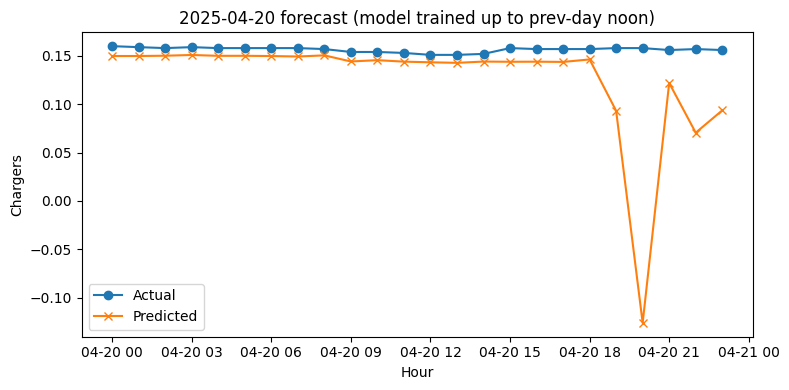

In [19]:
"""
24-hour forecast script (no-leakage, noon cut-off)

• Trains on every hour **up to 12:00 (noon) of the calendar day BEFORE
  TARGET_DATE**.
• Uses those frozen stats to forecast the full 24 h of TARGET_DATE.
• If the day is already in the CSV, prints MAE / RMSE / R²; otherwise it
  just plots the forecast.

Run this at ~12:05 every work-day and you’ll have tomorrow’s forecast
with the latest half-day of metered data included, but no look-ahead.
"""

import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─── USER SETTINGS ───────────────────────────────────────────────────────────
CSV_PATH     = "./Charging_data_13-05.csv"
TARGET_DATE  = "2025-04-20"          # YYYY-MM-DD  (day you want to forecast)
SESSION_KWH  = 9.5                   # fleet-weighted kWh per vehicle
# ─────────────────────────────────────────────────────────────────────────────

# 1) LOAD DATA
df = pd.read_csv(CSV_PATH)
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})       # hourly kWh

# 2) STATIC CALENDAR FLAGS
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# 3) CORE TIME FLAGS
df['weekday']      = df['ds'].dt.weekday          # 0 = Mon
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# 4) TRAIN/FORECAST SPLIT  (train < previous-day-noon)
cutoff = (pd.Timestamp(TARGET_DATE).normalize()   # 00:00 of target day
          - pd.Timedelta(hours=12))               # => 12:00 previous day
train  = df[df['ds'] < cutoff].copy()
if train.empty:
    raise ValueError("No history before the noon cut-off.")

# 5) TRAIN-ONLY STATISTICS
avg_hourly = (
    train.groupby(['weekday','hour'])['y']
          .mean().rename('avg_hourly_by_weekday')
          .reset_index()
)
train = train.merge(avg_hourly, on=['weekday','hour'], how='left')

train['cars_charged_hour'] = train['y'] / SESSION_KWH
avg_cars_wd = (
    train.groupby('weekday')['cars_charged_hour']
         .mean().rename('avg_cars_weekday')
         .reset_index()
)
train = train.merge(avg_cars_wd, on='weekday', how='left')

# 6) LAG FEATURE (train slice only)
train['lag_168'] = train['y'].shift(168).fillna(train['avg_hourly_by_weekday'])

FEATURES = [
    'is_weekend','is_work_hour','avg_hourly_by_weekday',
    'is_holiday','is_terugkomdag',
    'lag_168','avg_cars_weekday'
]

# 7) TRAIN MODEL
model = lgb.LGBMRegressor(
    objective='quantile', alpha=0.55,
    n_estimators=800, learning_rate=0.05,
    random_state=42
).fit(train[FEATURES], train['y'])

# 8) BUILD 24-H FEATURE FRAME FOR TARGET_DATE
day_start = pd.Timestamp(TARGET_DATE).normalize()
future_idx = pd.date_range(day_start, periods=24, freq='H')

day_df = pd.DataFrame({'ds': future_idx})
day_df['weekday']      = day_df['ds'].dt.weekday
day_df['hour']         = day_df['ds'].dt.hour
day_df['is_weekend']   = (day_df['weekday'] >= 5).astype(int)
day_df['is_work_hour'] = ((day_df['hour'] >= 8) & (day_df['hour'] <= 18)).astype(int)
day_df['is_holiday']     = day_df['ds'].dt.normalize().isin(be_holidays).astype(int)
day_df['is_terugkomdag'] = day_df['ds'].dt.normalize().isin(tkd).astype(int)

day_df = day_df.merge(avg_hourly, on=['weekday','hour'], how='left')
day_df = day_df.merge(avg_cars_wd, on='weekday', how='left')

# lag_168 (value 7 days ago from training slice)
lag_df = train[['ds','y']].copy()
lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
lag_df = lag_df.rename(columns={'y':'lag_168'})
day_df = day_df.merge(lag_df, on='ds', how='left')
day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

# 9) FORECAST
preds = []
for i in range(24):
    row = day_df.iloc[[i]].copy()
    yhat = model.predict(row[FEATURES])[0]
    preds.append(yhat)

day_df['yhat'] = preds

# 10) METRICS IF ACTUALS EXIST
actual_mask = (df['ds'] >= day_start) & (df['ds'] < day_start + pd.Timedelta(days=1))
if actual_mask.any():
    actual = df.loc[actual_mask, ['ds','y']].reset_index(drop=True)
    merged = actual.merge(day_df[['ds','yhat']], on='ds')
    mae  = mean_absolute_error(merged['y'], merged['yhat'])
    rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
    r2   = r2_score(merged['y'], merged['yhat'])
    print(f"\n◇ {TARGET_DATE}  (metrics with noon cut-off)")
    print(f"MAE : {mae:.2f}   RMSE: {rmse:.2f}   R²: {r2:.2f}")
else:
    print(f"\n◇ {TARGET_DATE} is future-only → metrics not available.")

# 11) PLOT FORECAST
plt.figure(figsize=(8,4))
if actual_mask.any():
    plt.plot(merged['ds'], merged['y'],   label='Actual',    marker='o')
    plt.plot(merged['ds'], merged['yhat'],label='Predicted', marker='x')
else:
    plt.plot(day_df['ds'], day_df['yhat'], label='Forecast', marker='x')
plt.title(f"{TARGET_DATE} forecast (model trained up to prev-day noon)")
plt.xlabel("Hour"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_2280\495168046.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 7
[LightGBM] [Info] Start training from score 11.209267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 437
[LightGBM] [Info] Number of data points in the train set: 6984, number of used features: 7
[LightGBM] [Info] Start training from score 11.171286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

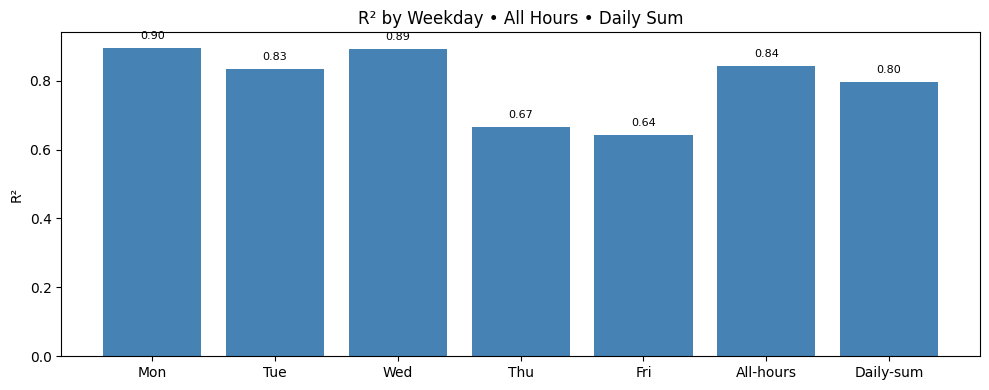

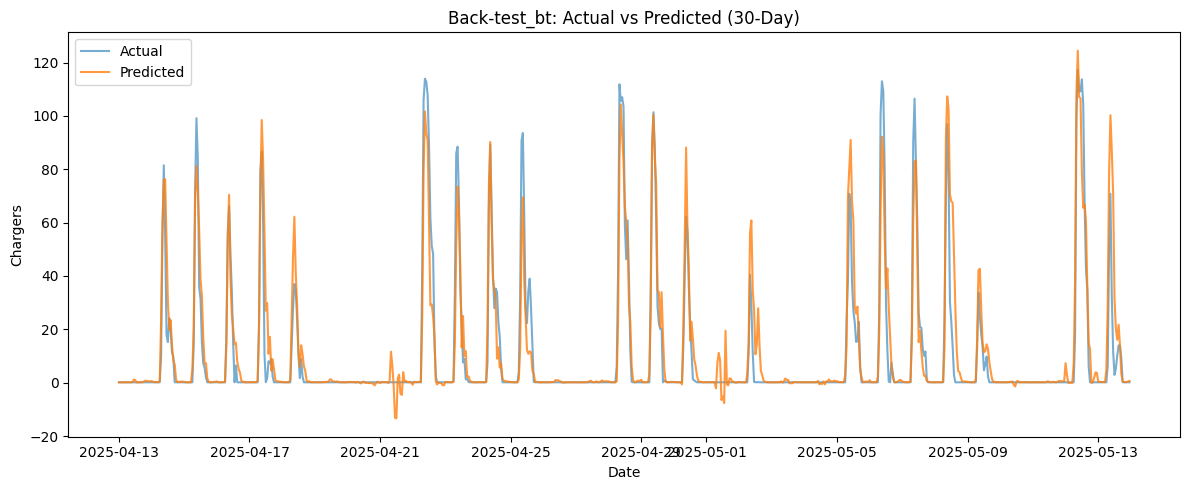

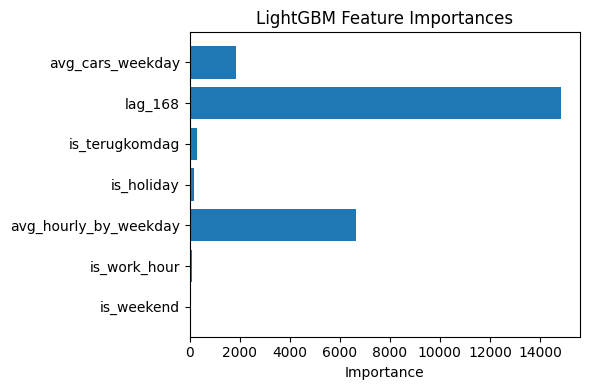

In [23]:
import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("./Charging_data_hourly.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})    # hourly kWh

# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# core time flags
df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)
                       # average energy per vehicle-session

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

all_preds = []                            # collect daily predictions

for day in days_iter:
    day_start = pd.Timestamp(day)         # 00:00 of target day
    day_end   = day_start + pd.Timedelta(days=1)

    # ──  TRAIN slice: everything before 00:00 of this day  ──
    train = df[df['ds'] < day_start].copy()
    # derive weekday/hour mean & weekday car average on **train only**
    avg_map = (train.groupby(['weekday','hour'])['y']
                     .mean().rename('avg_hourly_by_weekday')
                     .reset_index())
    train['lag_168'] = train['y'].shift(168).fillna(train['y'].mean())                      # fallback mean
    
    train = train.merge(avg_map, on=['weekday','hour'], how='left')
    train['avg_cars_weekday'] = (
        train.groupby('weekday')['y'].transform('mean') / SESSION_KWH
    )

    FEATURES = [
        'is_weekend','is_work_hour','avg_hourly_by_weekday',
        'is_holiday','is_terugkomdag',
        'lag_168','avg_cars_weekday'
    ]

    model = lgb.LGBMRegressor(
        objective='regression', alpha=0.55,
        n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train['y'])

    # ──  BUILD feature frame for the 24 h of this day  ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday','hour'], how='left')

    lag_df = train[['ds','y']].copy()
    lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
    lag_df.rename(columns={'y':'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

    

    cars_map = (train.groupby('weekday')['y'].mean() / SESSION_KWH
                ).rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # predict all 24 rows
    day_df['yhat'] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[['ds','y','yhat','weekday']])

# ────────── CONCAT results & evaluate ──────────
test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

# ═════════════════ 7. METRICS ════════════════════════════════════════════════
mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test_bt Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {
    weekday_map[d]:
    r2_score(
        test_bt.loc[test_bt['weekday']==d,'y'],
        test_bt.loc[test_bt['weekday']==d,'yhat']
    )
    for d in range(5)
}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
    y_sum=('y','sum'),
    yhat_sum=('yhat','sum')
)
r2_daily = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 8. PLOTS ════════════════════════════════════════════════
# R² bar plot
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily]
plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Time-series plot & feature importances
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test_bt: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_24984\2923092874.py:54: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 8
[LightGBM] [Info] Start training from score 11.209267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 6984, number of used features: 8
[LightGBM] [Info] Start training from score 11.171286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

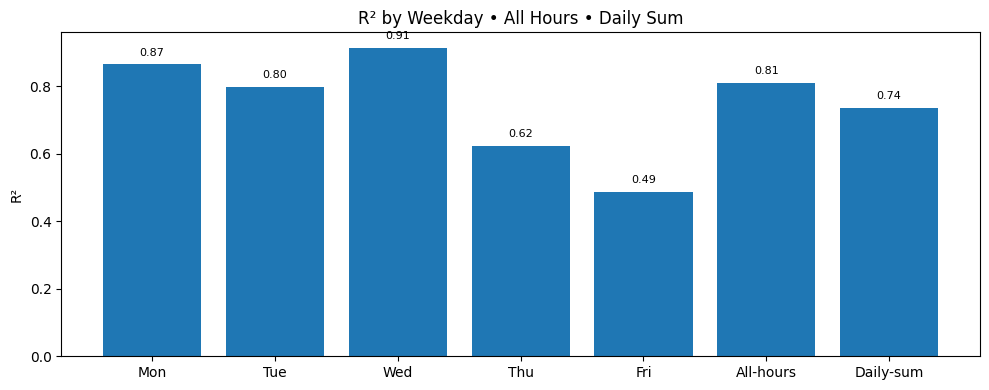

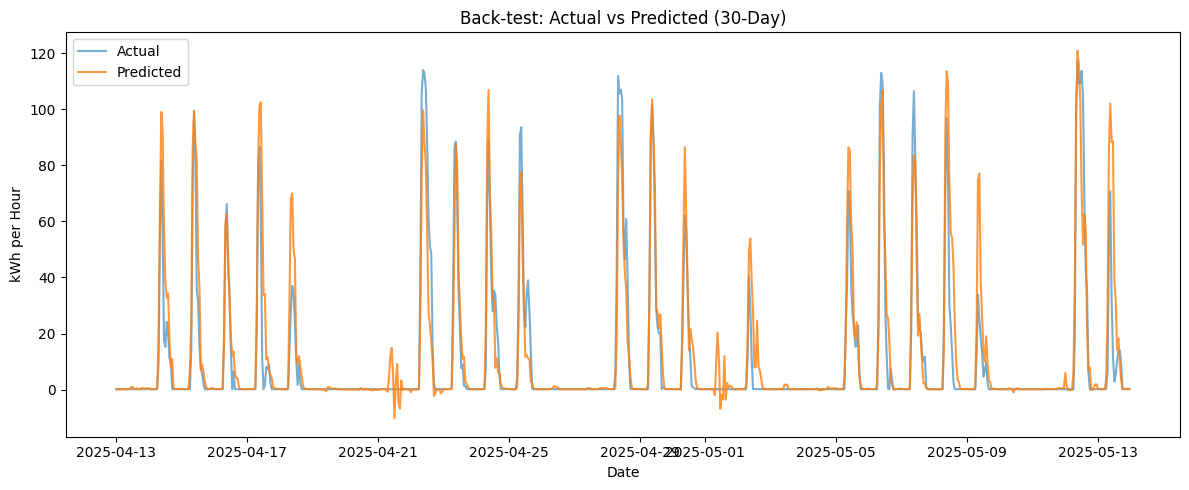

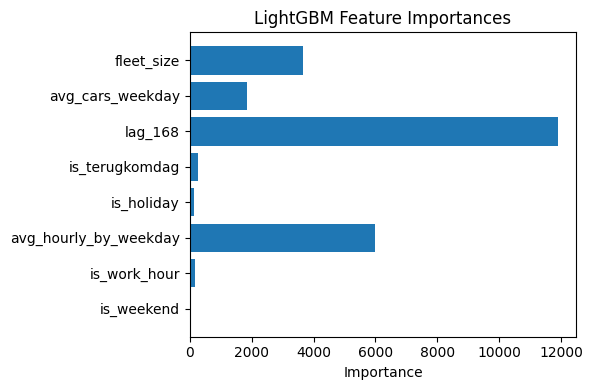

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\inspection\__init__.py)

In [4]:
import pandas as pd
import numpy as np
import holidays
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date, timedelta

# ─────────────────────── 0. DEFINE NEW FEATURES ───────────────────────
# Fleet rollout timeline
fleet_timeline = {
    date(2024,6,20): 35, date(2024,6,25): 36, date(2024,9,5): 38,
    date(2024,9,12): 41, date(2024,9,27): 42, date(2024,10,15): 43,
    date(2024,10,29): 45, date(2024,11,5): 46, date(2024,11,26): 47,
    date(2025,1,9): 48, date(2025,1,23): 49, date(2025,1,28): 50,
    date(2025,2,4): 51
}

def fleet_size_for(dt):
    """Return the fleet size as of date dt (a datetime.date)."""
    # find all rollout dates ≤ dt, pick the most recent
    past = [d for d in fleet_timeline if d <= dt]
    return fleet_timeline[max(past)] if past else min(fleet_timeline.values())

def is_bridge_day(dt, be_holidays):
    """Flag a 'bridge' day: Fri before or Mon after a Belgian holiday."""
    # ensure dt is a date
    d = dt.date() if hasattr(dt, 'date') else dt
    return int(
        (d.weekday() == 4 and (d - timedelta(days=1)) in be_holidays) or
        (d.weekday() == 0 and (d + timedelta(days=1)) in be_holidays)
    )

# ─────────────────────── 1. LOAD DATA ───────────────────────
df = pd.read_csv("./Charging_data_hourly.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})

# ─────────────────────── 2. STATIC CALENDARS & FLAGS ─────────────────────
# Terugkomdag dates
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()

# Belgian holidays calendar
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

# Base flags
df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)
df['weekday']        = df['ds'].dt.weekday
df['hour']           = df['ds'].dt.hour
df['is_weekend']     = (df['weekday'] >= 5).astype(int)
df['is_work_hour']   = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# ─────────────────────── 3. NEW FEATURE COLUMNS ───────────────────────
# fleet_size and is_bridge_day
df['fleet_size'] = df['ds'].dt.normalize().apply(lambda x: fleet_size_for(x.date()))
df['is_bridge']  = df['ds'].apply(lambda x: is_bridge_day(x, be_holidays))

SESSION_KWH = 9.5  # average energy per vehicle-session

# ─────────────────────── 4. BACKTEST LOOP ───────────────────────
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(), df['ds'].max().normalize(), freq='D')
all_preds = []

for day in days_iter:
    day_start = pd.Timestamp(day)
    day_end   = day_start + pd.Timedelta(days=1)

    # TRAIN slice
    train = df[df['ds'] < day_start].copy()
    avg_map = (train.groupby(['weekday','hour'])['y']
                     .mean().rename('avg_hourly_by_weekday').reset_index())
    train['lag_168'] = train['y'].shift(168).fillna(train['y'].mean())
    train = train.merge(avg_map, on=['weekday','hour'], how='left')
    train['avg_cars_weekday'] = train.groupby('weekday')['y'].transform('mean') / SESSION_KWH

    FEATURES = [
        'is_weekend','is_work_hour','avg_hourly_by_weekday',
        'is_holiday','is_terugkomdag','lag_168','avg_cars_weekday',
        'fleet_size'
    ]

    model = lgb.LGBMRegressor(
        objective='regression', alpha=0.55,
        n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train['y'])

    # BUILD day's feature frame
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday','hour'], how='left')

    lag_df = train[['ds','y']].copy()
    lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
    lag_df.rename(columns={'y':'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

    cars_map = (train.groupby('weekday')['y'].mean() / SESSION_KWH
                ).rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # PREDICT
    day_df['yhat'] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[['ds','y','yhat','weekday']])

# ─────────────────────── 5. EVALUATE & PLOT ───────────────────────
test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {
    weekday_map[d]:
    r2_score(
        test_bt.loc[test_bt['weekday']==d,'y'],
        test_bt.loc[test_bt['weekday']==d,'yhat']
    )
    for d in range(5)
}
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
    y_sum=('y','sum'),
    yhat_sum=('yhat','sum')
)
r2_daily = r2_score(daily['y_sum'], daily['yhat_sum'])

# PLOTS
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily]
plt.figure(figsize=(10,4))
bars = plt.bar(labels, values)
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date"); plt.ylabel("kWh per Hour"); plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

from sklearn.inspection import partial_dependence, plot_partial_dependence
plot_partial_dependence(model, train[FEATURES], ['fleet_size','is_bridge'])


C:\Users\user\AppData\Local\Temp\ipykernel_4284\4093803227.py:24: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 7
[LightGBM] [Info] Start training from score 11.209267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 6984, number of used features: 7
[LightGBM] [Info] Start training from score 11.171286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

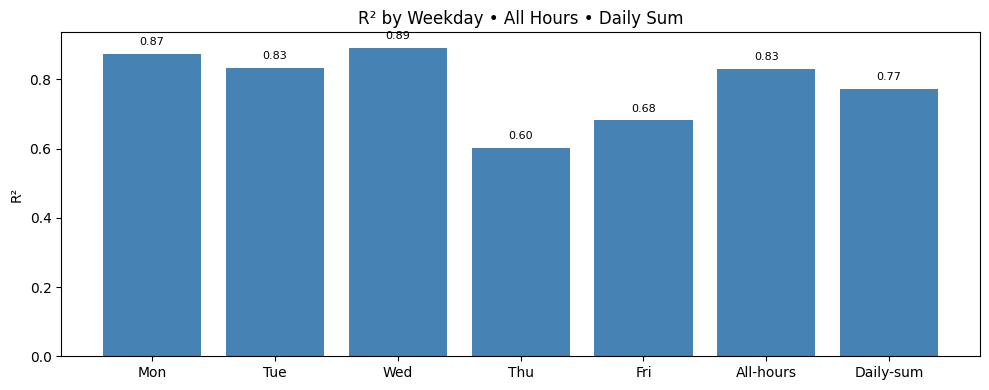

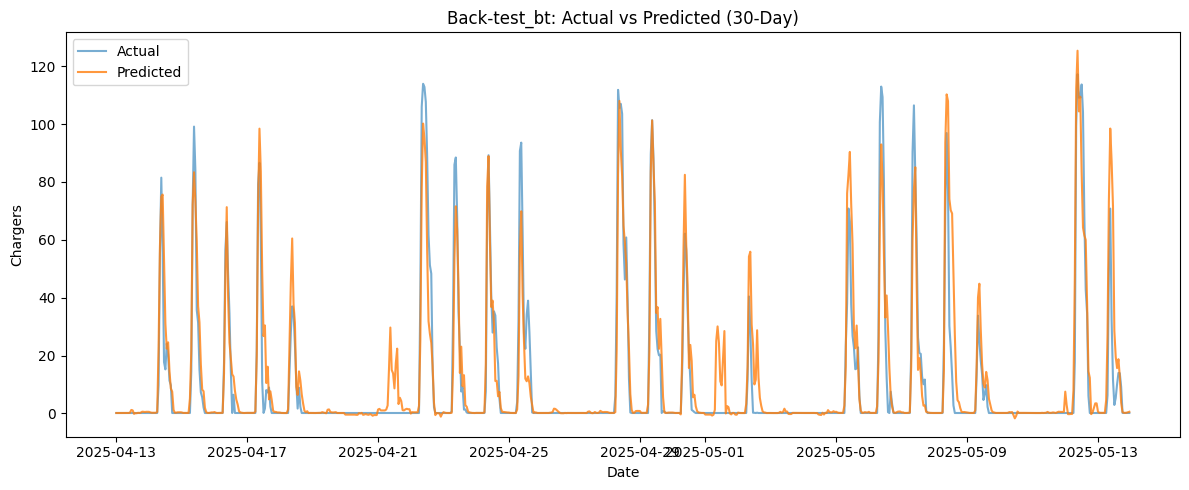

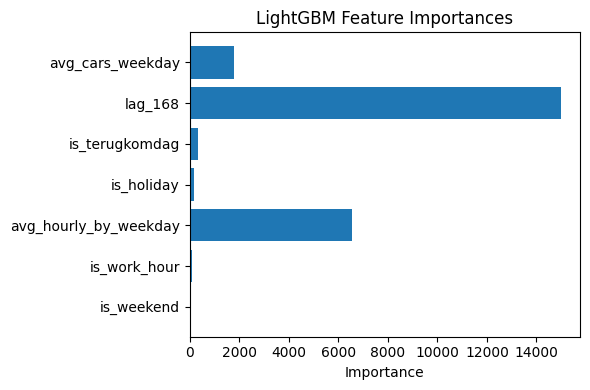

In [4]:
import pandas as pd
import numpy as np
import holidays
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("./Charging_data_hourly.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})    # hourly kWh

# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# placeholder: replace with your actual per-session kWh constant
SESSION_KWH = 9.5 

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

all_preds = []

for day in days_iter:
    day_start = pd.Timestamp(day)
    day_end   = day_start + pd.Timedelta(days=1)

    # ── TRAIN slice ──
    train = df[df['ds'] < day_start].copy()

    # 1) Exclude holidays from weekday-hour average
    non_holiday_train = train[train['is_holiday']==0]
    avg_map = (
        non_holiday_train
        .groupby(['weekday','hour'])['y']
        .mean()
        .rename('avg_hourly_by_weekday')
        .reset_index()
    )

    # lag-168 (one week) feature
    train['lag_168'] = train['y'].shift(168).fillna(train['y'].mean())

    # merge avg_hourly_by_weekday
    train = train.merge(avg_map, on=['weekday','hour'], how='left')

    # average cars per weekday
    train['avg_cars_weekday'] = (
        train.groupby('weekday')['y'].transform('mean') / SESSION_KWH
    )

    FEATURES = [
        'is_weekend','is_work_hour',
        'avg_hourly_by_weekday',
        'is_holiday','is_terugkomdag',
        'lag_168','avg_cars_weekday'
    ]

    model = lgb.LGBMRegressor(
        objective='regression', alpha=0.55,
        n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train['y'])

    # ── BUILD prediction frame ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday','hour'], how='left')

    # lag-168 for the prediction day
    lag_df = train[['ds','y']].copy()
    lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
    lag_df.rename(columns={'y':'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

    # 2) Zero out lag on holidays
    day_df.loc[day_df['is_holiday']==1, 'lag_168'] = 0

    # avg_cars_weekday for prediction
    cars_map = (
        train.groupby('weekday')['y'].mean() / SESSION_KWH
    ).rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # predict
    day_df['yhat'] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[['ds','y','yhat','weekday']])

# ── CONCAT & EVAL ──
test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)


# ═════════════════ 7. METRICS ════════════════════════════════════════════════
mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test_bt Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {
    weekday_map[d]:
    r2_score(
        test_bt.loc[test_bt['weekday']==d,'y'],
        test_bt.loc[test_bt['weekday']==d,'yhat']
    )
    for d in range(5)
}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
    y_sum=('y','sum'),
    yhat_sum=('yhat','sum')
)
r2_daily = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 8. PLOTS ════════════════════════════════════════════════
# R² bar plot
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily]
plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Time-series plot & feature importances
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test_bt: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Temp\ipykernel_2280\329925386.py:28: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)
12:08:28 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1] done processing
12:08:31 - cmdstanpy - INFO - Chain [1] start processing
12:08:31 - cmdstanpy - INFO - Chain [1] done processing



Rolling one-day forecast over 30 d  →  MAE=6.55  RMSE=13.28  R²=0.70


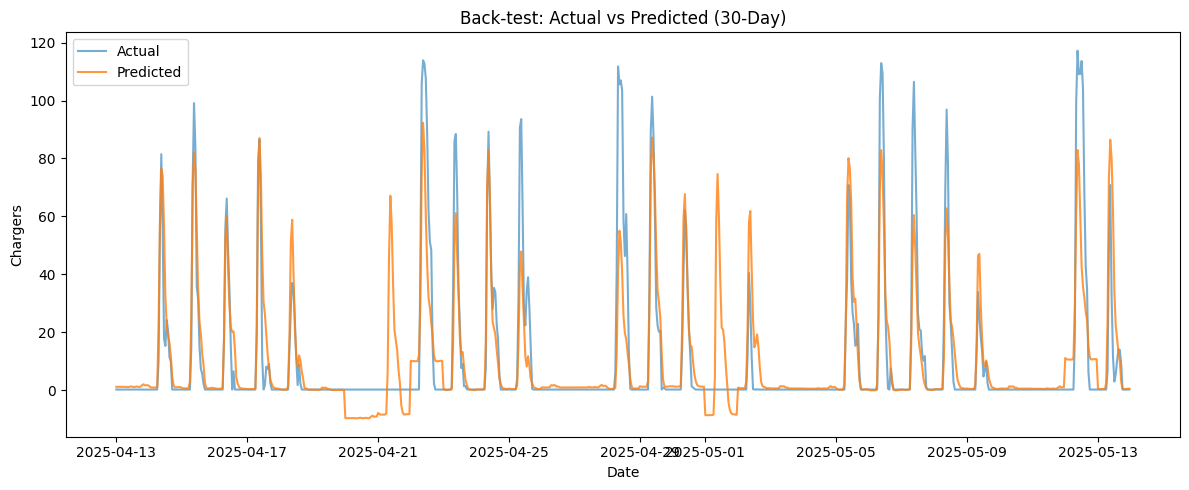

In [6]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("./Charging_data_13-05.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})  # hourly kWh

# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13", "2023-10-26", "2023-11-14", "2023-12-20",
    "2024-01-12", "2024-02-07", "2024-03-14", "2024-04-16",
    "2024-05-13", "2024-06-07", "2024-10-22", "2024-11-28",
    "2024-12-18", "2025-01-10", "2025-02-13", "2025-03-18",
    "2025-04-22", "2025-05-12", "2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

# core time flags
df['weekday'] = df['ds'].dt.weekday
df['hour'] = df['ds'].dt.hour
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)
df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

SESSION_KWH = 9.5  # average energy per vehicle-session

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

FEATURES = [
    'is_weekend', 'is_work_hour', 'avg_hourly_by_weekday',
    'is_holiday', 'is_terugkomdag', 'lag_168', 'avg_cars_weekday'
]

all_preds = []  # collect daily predictions

for day in days_iter:
    day_start = pd.Timestamp(day)  # 00:00 of target day
    day_end = day_start + pd.Timedelta(days=1)

    # ── TRAIN slice: everything before 00:00 of this day ──
    train = df[df['ds'] < day_start].copy()

    # derive weekday/hour mean & weekday car average on **train only**
    avg_map = (train.groupby(['weekday', 'hour'])['y']
                     .mean().rename('avg_hourly_by_weekday')
                     .reset_index())
    train = train.merge(avg_map, on=['weekday', 'hour'], how='left')

    # 7-day lag (168 hours)
    train['lag_168'] = train['y'].shift(168)
    train['lag_168'] = train['lag_168'].fillna(train['y'].mean())  # fallback

    # simple 6-hour EWM on non-holidays (kept only for continuity)
    train['ewm_mean_6h'] = train['y'].ewm(span=6).mean()
    train.loc[train['is_holiday'] == 1, 'ewm_mean_6h'] = 0

    # weekday average number of charging sessions
    train['avg_cars_weekday'] = (
        train.groupby('weekday')['y'].transform('mean') / SESSION_KWH
    )

    # Prophet requires all regressors to be present & numeric
    reg_train = train[['ds', 'y'] + FEATURES].copy()

    # ──  Fit Prophet  ──
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        
    )
    for reg in FEATURES:
        m.add_regressor(reg)

    m.fit(reg_train)

    # ── BUILD feature frame for the 24 h of this day ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday', 'hour'], how='left')

    # bring 7-day lag from training slice
    lag_df = train[['ds', 'y']].copy()
    lag_df['ds'] += pd.Timedelta(days=7)
    lag_df.rename(columns={'y': 'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

    # keep last EWM value (used only to preserve original logic)
    last_ewm = train['ewm_mean_6h'].iloc[-1]
    day_df['ewm_mean_6h'] = np.where(day_df['is_holiday'] == 1, 0, last_ewm)

    # weekday car average on training slice
    cars_map = (train.groupby('weekday')['y'].mean() / SESSION_KWH)
    cars_map = cars_map.rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # prepare future dataframe for Prophet
    future = day_df[['ds'] + FEATURES].copy()

    forecast = m.predict(future)
    day_df['yhat'] = forecast['yhat']

    all_preds.append(day_df[['ds', 'y', 'yhat', 'weekday']])

# ────────── CONCAT results & evaluate ──────────

test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

mae = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2 = r2_score(test_bt['y'], test_bt['yhat'])
print(f"\nRolling one-day forecast over 30 d  →  MAE={mae:.2f}  RMSE={rmse:.2f}  R²={r2:.2f}")

# optional: plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(test_bt['ds'], test_bt['y'], label='Actual', alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()
